# Ungraded Lab: Fairness Indicators

In this colab notebook, you will use [Fairness Indicators](https://www.tensorflow.org/tfx/guide/fairness_indicators) to explore the `Smiling` attribute in a large-scale face image dataset. Fairness Indicators is a suite of tools built on top of [TensorFlow Model Analysis](https://www.tensorflow.org/tfx/model_analysis/get_started) that enable regular evaluation of fairness metrics in product pipelines. This [Introductory Video](https://www.youtube.com/watch?v=pHT-ImFXPQo) provides more details and context on the real-world scenario presented here, one of primary motivations for creating Fairness Indicators. This notebook will teach you to:


*   Train a simple neural network model to detect a person's smile in images using [TF Keras](https://www.tensorflow.org/guide/keras) and the [CelebFaces Attributes (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset.
*   Evaluate model performance against a commonly used fairness metric across age groups using Fairness Indicators.

*Credits: Some of the code and discussions are taken from this [Tensorflow tutorial](https://colab.research.google.com/github/tensorflow/fairness-indicators/blob/master/g3doc/tutorials/Fairness_Indicators_TFCO_CelebA_Case_Study.ipynb).*

## Install Fairness Indicators

This will install all related libraries such as TFMA and TFDV.

In [1]:
!pip install fairness-indicators

*Note: In Google Colab, you need to restart the runtime at this point to finalize updating the packages you just installed. You can do so by clicking the `Restart Runtime` at the end of the output cell above (after installation), or by selecting `Runtime > Restart Runtime` in the Menu bar. **Please do not proceed to the next section without restarting.** You can also ignore the errors about version incompatibility of some of the bundled packages because we won't be using those in this notebook.*

## Import packages

Next, you will import the main packages and some utilities you will need in this notebook. Notice that you are not importing `fairness-indicators` directly. As mentioned in the intro, this suite of tools is built on top of TFMA so you can just import TFMA to access it.

In [2]:
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tensorflow_datasets as tfds
from tensorflow import keras

The code below should not produce any error. Otherwise, please restart the installation.

In [3]:
print("TensorFlow " + tf.__version__)
print("TFMA " + tfma.VERSION_STRING)

TensorFlow 2.5.0
TFMA 0.30.0


## Download and prepare the dataset

[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200,000 celebrity images, each with 40 attribute annotations (such as hair type, fashion accessories, facial features, etc.) and 5 landmark locations (eyes, mouth and nose positions). For more details, you can read more in [this paper](https://liuziwei7.github.io/projects/FaceAttributes.html).

With the permission of the owners, this dataset is stored on Google Cloud Storage (GCS) and mostly accessed via [TensorFlow Datasets(`tfds`)](https://www.tensorflow.org/datasets). To save on download time and disk space, you will use the GCS bucket specified below as your data directory. This already contains the TFRecords. If you want to download it to your workspace, you can pass a local directory to the `data_dir` argument. Just take note that it will take time to complete the download.




In [4]:
# URI of the dataset in Goocle Cloud Storage
GCS_BASE_DIR = "gs://celeb_a_dataset/"

# Load the data using TFDS
data, data_info = tfds.load("celeb_a", data_dir=GCS_BASE_DIR, with_info=True, builder_kwargs={'version':'2.0.0'})

You can preview some of the images in the dataset.

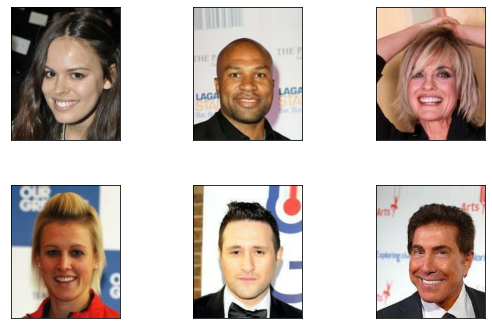

In [5]:
# Take 6 examples and preview images
fig = tfds.show_examples(data['train'].take(6), data_info)

You can also view the dataset as a dataframe to preview the other attributes in tabular format.

In [6]:
# Take 4 examples as a dataframe
df = tfds.as_dataframe(data['train'].take(4), data_info)

# View the dataframe
df.head()

,attributes/5_o_Clock_Shadow,attributes/Arched_Eyebrows,attributes/Attractive,attributes/Bags_Under_Eyes,attributes/Bald,attributes/Bangs,attributes/Big_Lips,attributes/Big_Nose,attributes/Black_Hair,attributes/Blond_Hair,attributes/Blurry,attributes/Brown_Hair,attributes/Bushy_Eyebrows,attributes/Chubby,attributes/Double_Chin,attributes/Eyeglasses,attributes/Goatee,attributes/Gray_Hair,attributes/Heavy_Makeup,attributes/High_Cheekbones,attributes/Male,attributes/Mouth_Slightly_Open,attributes/Mustache,attributes/Narrow_Eyes,attributes/No_Beard,attributes/Oval_Face,attributes/Pale_Skin,attributes/Pointy_Nose,attributes/Receding_Hairline,attributes/Rosy_Cheeks,attributes/Sideburns,attributes/Smiling,attributes/Straight_Hair,attributes/Wavy_Hair,attributes/Wearing_Earrings,attributes/Wearing_Hat,attributes/Wearing_Lipstick,attributes/Wearing_Necklace,attributes/Wearing_Necktie,attributes/Young,image,landmarks/lefteye_x,landmarks/lefteye_y,landmarks/leftmouth_x,landmarks/leftmouth_y,landmarks/nose_x,landmarks/nose_y,landmarks/righteye_x,landmarks/righteye_y,landmarks/rightmouth_x,landmarks/rightmouth_y
0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,"[[[30, 32, 21], [30, 32, 21], [31, 33, 22], [3...",68,111,64,149,75,138,109,113,114,153
1,True,True,False,False,True,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,True,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,"[[[197, 195, 196], [179, 177, 178], [184, 182,...",69,111,68,151,90,133,108,112,109,152
2,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,"[[[252, 218, 183], [252, 218, 183], [252, 218,...",68,112,67,151,84,132,109,111,110,152
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False,False,True,True,False,True,False,True,False,False,True,"[[[45, 89, 138], [45, 89, 138], [46, 88, 138],...",69,111,69,153,85,136,107,111,108,152


Let's list the column header so you can see the attribute names in the dataset. For this notebook, you will just examine the `attributes/Young` and `attributes/Smiling` features but feel free to pick other features once you've gone over the whole exercise.

In [7]:
# List dataframe header
df.columns

Index(['attributes/5_o_Clock_Shadow', 'attributes/Arched_Eyebrows',
       'attributes/Attractive', 'attributes/Bags_Under_Eyes',
       'attributes/Bald', 'attributes/Bangs', 'attributes/Big_Lips',
       'attributes/Big_Nose', 'attributes/Black_Hair', 'attributes/Blond_Hair',
       'attributes/Blurry', 'attributes/Brown_Hair',
       'attributes/Bushy_Eyebrows', 'attributes/Chubby',
       'attributes/Double_Chin', 'attributes/Eyeglasses', 'attributes/Goatee',
       'attributes/Gray_Hair', 'attributes/Heavy_Makeup',
       'attributes/High_Cheekbones', 'attributes/Male',
       'attributes/Mouth_Slightly_Open', 'attributes/Mustache',
       'attributes/Narrow_Eyes', 'attributes/No_Beard', 'attributes/Oval_Face',
       'attributes/Pale_Skin', 'attributes/Pointy_Nose',
       'attributes/Receding_Hairline', 'attributes/Rosy_Cheeks',
       'attributes/Sideburns', 'attributes/Smiling',
       'attributes/Straight_Hair', 'attributes/Wavy_Hair',
       'attributes/Wearing_Earrings', 'a

In this notebook:
* Your model will attempt to classify whether the subject of the image is smiling, as represented by the `Smiling` attribute<sup>*</sup>.
*   Images will be resized from 218x178 to 28x28 to reduce the execution time and memory when training.
*   Your model's performance will be evaluated across age groups, using the binary `Young` attribute. You will call this "age group" in this notebook.

___

<sup>*</sup> *While there is little information available about the labeling methodology for this dataset, you will assume that the "Smiling" attribute was determined by a pleased, kind, or amused expression on the subject's face. For the purpose of this example, you will take these labels as ground truth.*

### Caveats
Before moving forward, there are several considerations to keep in mind when using CelebA:
*   Although, in principle, this notebook could use any dataset of face images, CelebA was chosen because it contains public domain images of public figures.
*   All of the attribute annotations in CelebA are operationalized as binary categories. For example, the `Young` attribute (as determined by the dataset labelers) is denoted as either present or absent in the image.
*   CelebA's categorizations do not reflect real human diversity of attributes.
*   For the purposes of this notebook, the feature containing the `Young` attribute is referred to as "age group". A `True` will put the image as a member of the `Young` age group and a `False` will put the image as a member of the `Not Young` age group. These are assumptions made as this information is not mentioned in the [original paper](http://openaccess.thecvf.com/content_iccv_2015/html/Liu_Deep_Learning_Face_ICCV_2015_paper.html).
*   As such, performance in the models trained in this notebook is tied to the ways the attributes have been operationalized and annotated by the authors of CelebA.
*   This model should not be used for commercial purposes as that would violate [CelebA's non-commercial research agreement](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

### Setting Up Input Functions

Now, you will define the preprocessing functions to prepare your data as model inputs. These include resizing images, normalizing pixels, casting to the right data type, and grouping the features and labels.

In [8]:
# Define Constants
ATTR_KEY = "attributes"
IMAGE_KEY = "image"
LABEL_KEY = "Smiling"
GROUP_KEY = "Young"
IMAGE_SIZE = 28

# Define Preprocessing Function
def preprocess_input_dict(feat_dict):
  ''' Picks the attributes to study and resizes the images
  Args:
    feat_dict (dictionary): features from the dataset

  Returns:
    dictionary containing the resized image, label, and age group
  '''
  # Separate out the image and target variable from the feature dictionary.
  image = feat_dict[IMAGE_KEY]
  label = feat_dict[ATTR_KEY][LABEL_KEY]
  group = feat_dict[ATTR_KEY][GROUP_KEY]

  # Resize and normalize image.
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0

  # Cast label and group to float32.
  label = tf.cast(label, tf.float32)
  group = tf.cast(group, tf.float32)

  # Put the computed values in a dictionary
  feat_dict[IMAGE_KEY] = image
  feat_dict[ATTR_KEY][LABEL_KEY] = label
  feat_dict[ATTR_KEY][GROUP_KEY] = group

  return feat_dict

# Define lambda functions to group features and labels for training and evaluation
get_image_and_label = lambda feat_dict: (feat_dict[IMAGE_KEY], feat_dict[ATTR_KEY][LABEL_KEY])
get_image_label_and_group = lambda feat_dict: (feat_dict[IMAGE_KEY], feat_dict[ATTR_KEY][LABEL_KEY], feat_dict[ATTR_KEY][GROUP_KEY])

## Prepare train and test splits

This next helper function will help split, shuffle, batch and preprocess your training data. For this notebook, you will just develop a model that accepts the image as input and outputs the `Smiling` attribute (i.e. label).

In [9]:
def celeb_a_train_data_wo_group(data, batch_size):
  '''
  Args:
    data (TF dataset) - dataset to preprocess
    batch_size (int) - batch size
  
  Returns:
    Batches of preprocessed datasets containing tuples with (image, label)
  '''
  celeb_a_train_data = data.shuffle(1024).repeat().batch(batch_size).map(preprocess_input_dict)
  return celeb_a_train_data.map(get_image_and_label)

The `test` split does not need to be shuffled so you can just preprocess it like below.

In [10]:
# Prepare test data
celeb_a_test_data = data['test'].batch(1).map(preprocess_input_dict).map(get_image_label_and_group)

As a sanity check, you can examine the contents of a one example in the test data. You should see that it is successfully reshaped and the pixels should be normalized.

In [11]:
# Print info about the test data records
for sample in celeb_a_test_data.take(1):
  print(f'Data type: {type(sample)}')
  print(f'Number of elements: {len(sample)}')
  print(f'Shape of 1st element: {sample[0].shape}')
  print(f'Shape of 2nd element: {sample[1].shape}')
  print(f'Shape of 3rd element: {sample[2].shape}')
  print(f'Contents: \n{sample}')

Data type: <class 'tuple'>
Number of elements: 3
Shape of 1st element: (1, 28, 28, 3)
Shape of 2nd element: (1,)
Shape of 3rd element: (1,)
Contents: 
(<tf.Tensor: shape=(1, 28, 28, 3), dtype=float32, numpy=
array([[[[0.81317526, 0.7912615 , 0.72465986],
         [0.85708785, 0.83748   , 0.7542867 ],
         [0.8946379 , 0.86615646, 0.77189875],
         ...,
         [0.527636  , 0.3903811 , 0.16293013],
         [0.5096639 , 0.3841737 , 0.15280116],
         [0.5019608 , 0.3882353 , 0.15294118]],

        [[0.7951531 , 0.75985897, 0.69963485],
         [0.7954932 , 0.7562775 , 0.7156613 ],
         [0.80069023, 0.76064926, 0.7249299 ],
         ...,
         [0.5149909 , 0.3777361 , 0.1502851 ],
         [0.50980395, 0.38431373, 0.15294118],
         [0.5019608 , 0.3882353 , 0.15294118]],

        [[0.74019605, 0.6931372 , 0.6382353 ],
         [0.757418  , 0.71035916, 0.6554572 ],
         [0.7790216 , 0.7319077 , 0.6804222 ],
         ...,
         [0.49884957, 0.3802521 , 0.15848

## Build a simple DNN Model

With the dataset prepared, you will now assemble a simple `tf.keras.Sequential` model to classify your images. The model consists of:

1. An input layer that represents the flattened 28x28x3 image.
2. A fully connected layer with 64 units activated by a ReLU function.
3. A single-unit readout layer to output real-scores instead of probabilities.

You may be able to greatly improve model performance by adding some complexity (e.g., more densely-connected layers, exploring different activation functions, increasing image size), but that may distract from the goal of demonstrating how easy it is to apply the indicators when working with Keras. For that reason, you will first keep the model simple — but feel free to explore this space later.

In [12]:
def create_model():
  '''Builds the simple DNN binary classifier'''

  # Build the model using the Sequential API
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='image'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1, activation=None)
  ])

  # Compile the model with hinge loss and binary accuracy metric
  model.compile(
      optimizer=tf.keras.optimizers.Adam(0.001),
      loss='hinge',
      metrics='binary_accuracy')
  
  return model


## Train & Evaluate Model

You’re now ready to train your model. To cut back on the amount of execution time and memory, you will train the model by slicing the data into small batches with only a few repeated iterations.

In [13]:
BATCH_SIZE = 32

# Build the model
model = create_model()

# Train the model
model.fit(celeb_a_train_data_wo_group(data['train'], BATCH_SIZE), epochs=5, steps_per_epoch=1000)

Epoch 1/5
1000/1000 [==============================] - 31s 27ms/step - loss: 0.5043 - binary_accuracy: 0.7689
Epoch 2/5
1000/1000 [==============================] - 29s 29ms/step - loss: 0.3696 - binary_accuracy: 0.8339
Epoch 3/5
1000/1000 [==============================] - 26s 26ms/step - loss: 0.3602 - binary_accuracy: 0.8415
Epoch 4/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.3493 - binary_accuracy: 0.8426
Epoch 5/5
1000/1000 [==============================] - 23s 23ms/step - loss: 0.3250 - binary_accuracy: 0.8545


Evaluating the model on the test data should result in a final accuracy score of just over 85%. Not bad for a simple model with no fine tuning.

In [14]:
# Evaluate trained model on the test data
results = model.evaluate(celeb_a_test_data)

19962/19962 [==============================] - 49s 2ms/step - loss: 0.2332 - binary_accuracy: 0.8407


You will then save the model so you can analyze it in the next section.

In [15]:
# Define model directory
MODEL_LOCATION = 'saved_model'

# Save the model
model.save(MODEL_LOCATION, save_format='tf')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


## Model Analysis

As you already know, it is usually not enough to just measure your model's performance on global metrics. For instance, performance evaluated across age groups may reveal some shortcomings.

To explore this further, you will evaluate the model with Fairness Indicators via TFMA. In particular, you will see whether there is a significant gap in performance between "Young" and "Not Young" categories when evaluated on false positive rate (FPR).

A false positive error occurs when the model incorrectly predicts the positive class. In this context, a false positive outcome occurs when the ground truth is an image of a celebrity 'Not Smiling' and the model predicts 'Smiling'. While this seems like a relatively mundane error, false positive errors can sometimes cause more problematic behaviors when deployed in a real world application. For instance, a false positive error in a spam classifier could cause a user to miss an important email.

You will mostly follow the same steps as you did in the first ungraded lab of this week. Namely, you will:

* Create a TFRecord of the test dataset.
* Write an `EvalConfig` file
* Create an `EvalSharedModel`
* Define a `Schema` message
* Run model analysis with TFMA

### Create TFRecord

You will need to serialize the preprocessed test dataset so it can be read by TFMA. We've provided a helper function to do just that. Notice that the age group feature is transformed into a string ('Young' or 'Not Young'). This will come in handy in the visualization so the tags are easier to interpret (compared to just 1 or 0).

In [16]:
# Define filename
TFRECORD_FILE = 'celeb_a_test.tfrecord'

In [17]:
def celeb_ds_to_tfrecord(dataset, tfrecord_file):
  ''' Helper function to convert a TF Dataset to TFRecord

  Args:
    dataset (TF Dataset) - dataset to save as TFRecord
    tfrecord_file (string) - filename to use when writing the TFRecord
  '''

  # Initialize examples list
  examples = []

  for row in dataset:
    # Get image, label, and group tensors
    image = row[0]
    label = row[1]
    group = row[2]

    # Flatten image
    image = tf.reshape(image, [-1])

    # Instantiate Example
    output = tf.train.Example()

    # Assign features' numpy arrays to the Example feature values
    output.features.feature[IMAGE_KEY].float_list.value.extend(image.numpy().tolist())
    output.features.feature[LABEL_KEY].float_list.value.append(label.numpy())
    output.features.feature[GROUP_KEY].bytes_list.value.append(b"Young" if group.numpy() else b'Not Young')
    
    # Append to examples list
    examples.append(output)

  # Serialize examples and save as tfrecord
  with tf.io.TFRecordWriter(tfrecord_file) as writer:
    for example in examples:
      writer.write(example.SerializeToString())

In [18]:
# Use the helper function to serialize the test dataset
celeb_ds_to_tfrecord(celeb_a_test_data, TFRECORD_FILE)

### Write EvalConfig file

Next, you will define the model, metrics, and slicing specs in an eval config file. As mentioned, you will slice the data across age groups to see if there is an underlying problem. For metrics, you will include the `FairnessIndicators` class. These are commonly-identified fairness metrics for binary and multiclass classifiers. Moreover, you will configure a list of thresholds. These will allow you to observe if the model predicts better when the threshold to determine between the two classes is changed (e.g. will the FPR be lower if the model predicts "Smiling" for outputs greater than 0.22?). 


In [19]:
# Import helper module
from google.protobuf import text_format

# Write EvalConfig string
eval_config_pbtxt = """
      model_specs {
        label_key: "%s"
      }
      metrics_specs {
        metrics {
          class_name: "FairnessIndicators"
          config: '{ "thresholds": [0.22, 0.5, 0.75] }'
        }
        metrics {
          class_name: "ExampleCount"
        }
      }
      slicing_specs {}
      slicing_specs { feature_keys: "%s" }
    """ % (LABEL_KEY, GROUP_KEY)

# Parse as a Message
eval_config = text_format.Parse(eval_config_pbtxt, tfma.EvalConfig())

### Create EvalSharedModel

This will be identical to the command you ran in an earlier lab. This is needed so TFMA will know how to load and configure your model from disk.

In [20]:
# Create EvalSharedModel
eval_shared_model = tfma.default_eval_shared_model(
      eval_saved_model_path=MODEL_LOCATION, eval_config=eval_config)

### Create a Schema

This is an additional step from your previous TFMA workflow. It is needed particularly because, unlike the TFMA ungraded lab, you didn't include a serving signature with the model. If you remember, the function called by that signature took care of parsing the tfrecords, converting them to the correct data type, and preprocessing. Since that part is not included in this lab, you will need to provide a schema so TFMA will know what data types are in the serialized examples when it parses the tfrecord into a dictionary of features. You will also need to define the dimensions of the image since that is expected by your model input. That is handled by the `tensor_representation_group` below.

In [21]:
from tensorflow_metadata.proto.v0 import schema_pb2
from google.protobuf import text_format

# Define Schema message as string
schema_pbtxt = """
      tensor_representation_group {
        key: ""
        value {
          tensor_representation {
            key: "%s"
            value {
              dense_tensor {
                column_name: "%s"
                shape {
                  dim { size: 28 }
                  dim { size: 28 }
                  dim { size: 3 }
                }
              }
            }
          }
        }
      }
      feature {
        name: "%s"
        type: FLOAT
      }
      feature {
        name: "%s"
        type: FLOAT
      }
      feature {
        name: "%s"
        type: BYTES
      }
      """ % (IMAGE_KEY, IMAGE_KEY, IMAGE_KEY, LABEL_KEY, GROUP_KEY)

# Parse the schema string to a message
schema = text_format.Parse(schema_pbtxt, schema_pb2.Schema())

### Run TFMA

You will pass the objects you created in the previous sections to `tfma.run_model_analysis()`. As you've done previously, this will take care of loading the model and data, and computing the metrics on the data slices you specified.

In [22]:
# Define output directory
OUTPUT_PATH = 'tfma_output'

# Run model analysis
eval_results = tfma.run_model_analysis(
    eval_shared_model=eval_shared_model,
    eval_config=eval_config,
    data_location=TFRECORD_FILE,
    schema=schema,
    output_path=OUTPUT_PATH
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Now you can view the fairness metrics you specified. The FPR should already be selected and you can see that it is considerably higher for the `Not Young` age group. Try to explore the widget and see if you can make other findings. Here are some suggestions:

* Toggle the threshold drop down and see how the FPR changes with different thresholds

* Change the baseline to `Young: Young` so the percentage difference (in the table below the chart) will be measured against it.

* Deselect the `Overall` slice so you can compare the two age groups side by side.

* Select other metrics to display and observe their charts.

In [23]:
# Visualize the fairness metrics
tfma.addons.fairness.view.widget_view.render_fairness_indicator(eval_results)

After studying the discrepancies in your predictions, you can then investigate why that happens and have a plan on remidiating it. Aside from changing your model architecture, you can also look first at your training data. `fairness-indicators` is also packaged with TFDV so you can use it to generate statistics from your data. Here is a short review on how to do that.

In [24]:
import tensorflow_data_validation as tfdv

# Define training directory
TRAIN_DIR = f'{GCS_BASE_DIR}celeb_a/2.0.0/celeb_a-train.tfrecord*'

# View tfrecord filenames in GCS
!gsutil ls {TRAIN_DIR}

gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00000-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00001-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00002-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00003-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00004-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00005-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00006-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00007-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00008-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00009-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00010-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00011-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00012-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tf

In [25]:
# Filter features to observe
stats_options = tfdv.StatsOptions(feature_allowlist=['attributes/Young'])

# Compute the statistics
statistics = tfdv.generate_statistics_from_tfrecord(TRAIN_DIR, stats_options=stats_options)

# Visualize the statistics
tfdv.visualize_statistics(statistics)

Connecting anonymously.


The statistics show that the `Not Young` age group (i.e. `0` in the `attributes/Young` column) has very few images compared to the `Young` age group. Maybe that's why the model learns on the `Young` images better. You could try adding more `Not Young` images and see if your model performs better on this slice.

## Wrap Up

In this lab, you prepared an image dataset and trained a model to predict one of its attributes (i.e. `Smiling`). You then sliced the data based on age groups and computed fairness metrics from the `Fairness Indicators` package via TFMA. Though the outcome looks simple, it is an important step in production ML projects because not detecting these problems can greatly affect the experience of your users. Improving these metrics will help you commit to fairness in your applications. We encourage you to try exploring more slices of the dataset and see what findings you can come up with.

For more practice, [here](https://colab.research.google.com/github/tensorflow/fairness-indicators/blob/master/g3doc/tutorials/Fairness_Indicators_Example_Colab.ipynb) is an official tutorial that uses fairness indicators on text data. It uses the [What-If-Tool](https://pair-code.github.io/what-if-tool/) which is another package that comes with `Fairness Indicators`. You will also get to explore that in this week's programming assignment.